## Bibliotheken

### Standard

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as pl

### selbst geschrieben

In [3]:
def Cat (*columns):
    return np.concatenate (columns, axis = 1)

In [4]:
def Col (matrix, column):
    return matrix [:, column] .reshape (-1, 1)

In [5]:
def Dist (u, v):
    return Norm (u - v)

In [6]:
def Dot (u, v):
    return u [0, 0] * v [0, 0] + u [1, 0] * v [1, 0]

In [7]:
def Iso ():
    pl.axis ('scaled')

In [8]:
def Norm (u):
    return np.sqrt (Dot (u, u))

In [9]:
def Vec (* coords):
    array = np.array (coords)
    return array.reshape (-1, 1)

## Kurve

In [10]:
def Curve (rho):
    phi = 2 * np.pi * rho
    pp = np.stack ((np.cos (phi), np.sin (phi)), axis = 0)
    return rho * pp

In [11]:
def PlotCurve (curve, color):
    pl.plot (curve [0], curve [1], color)

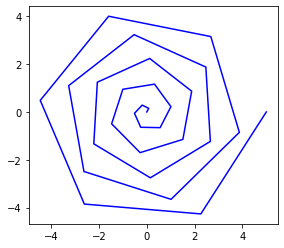

In [12]:
C = Curve (np.linspace (0, 5, 30))
PlotCurve (C, 'blue')
Iso()

## Rechteck

In [13]:
def Rect (xmin, xmax, ymin, ymax):
    return Cat (Vec (xmin, ymin), Vec (xmax, ymax))

In [14]:
def RectCurve (rect):
    a = Col (rect, 0)
    c = Col (rect, 1)
    b = Vec (c [0, 0], a [1, 0])
    d = Vec (a [0, 0], c [1, 0])
    return Cat (a, b, c, d, a)

In [15]:
def PlotRect (rect):
    curve = RectCurve (rect)
    PlotCurve (curve, 'black')

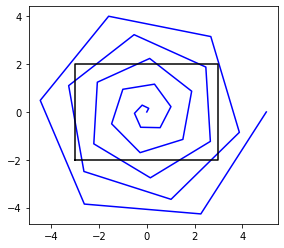

In [16]:
R = Rect (-3, 3, -2, 2)
PlotCurve (C, 'blue')
PlotRect (R)
Iso()

## Punkt im Rechteck?

In [17]:
def PointInRect (point, rect):
    # Liegt der Punkt im Rechteck?
    for i in range (2):
        if point [i, 0] < rect [i, 0]:
            return False
        if point [i, 0] > rect [i, 1]:
            return False
    return True

In [18]:
def PlotLine (a, b, color):
    p = Cat (a, b)
    pl.plot (p [0], p [1], color)

In [19]:
def ClipCurve0 (curve, rect):
    # Wenn beide Punkte innerhalb sind, dann rot -> Sonst blau
    a = Col (curve, 0); ai = PointInRect (a, rect)
    for i in range (1, curve.shape [1]):
        b = Col (curve, i); bi = PointInRect (b, rect)
        if ai and bi:
            PlotLine (a, b, 'red')
        else:
            PlotLine (a, b, 'blue')
        a = b; ai = bi

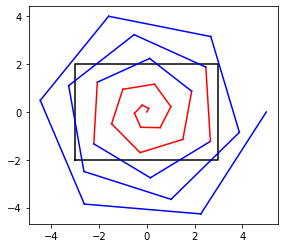

In [20]:
R = Rect (-3, 3, -2, 2)
PlotRect (R)
ClipCurve0 (C, R)
Iso()

## Line Clipping: Brut Force

In [21]:
def ClipLineBrutForce (p, q, rect):
    # Diskretisieren der Linien als einzelne Linien
    s = [0, 1]
    u = q - p
    for i in range (2):
        if u [i, 0] != 0:
            # Je nach dem wird geprüft ob vertikal oder horizontal geprüft wird
            # Sonst wird beim Algorithmus evt durch 0 dividiert
            for k in range (2):
                v = Col (rect, k) - p
                # p als Nullpunkt
                t = v [i, 0] / u [i, 0]
                # Teilungspunkt -> Nur wenn die Linie überschnitten wird
                if 0 <= t and t <= 1:
                    s.append (t)
    s.sort() #Alle überschreitungen und Start und Endpunkt [0, 0.2, 1.0]
    a = p; ai = PointInRect (a, rect)
    # Dann wird 
    for i in range (1, len (s)):
        b = p + s [i] * u; bi = PointInRect (b, rect)
        if ai and bi:
            PlotLine (a, b, 'red')
        else:
            PlotLine (a, b, 'blue')
        a = b; ai = bi

In [22]:
def ClipCurve (curve, rect, clipline):
    for i in range (curve.shape [1] - 1):
        clipline (Col (curve, i), Col (curve, i + 1), rect)

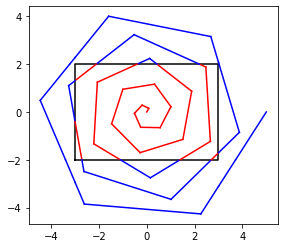

In [23]:
PlotRect (R)
ClipCurve (C, R, ClipLineBrutForce)
Iso()

## Line Clipping: Cohen-Sutherland

In [24]:
def ClipFlags (p, rect):
    # Flags erstellen
    flags = 0
    if p [0, 0] < rect [0, 0]:
        flags |= 1
    if p [0, 0] > rect [0, 1]:
        flags |= 2
    if p [1, 0] < rect [1, 0]:
        flags |= 4
    if p [1, 0] > rect [1, 1]:
        flags |= 8
    return flags

In [25]:
def ClipLineCohenSutherland0 (p, q, rect):
    f = ClipFlags (p, rect)
    g = ClipFlags (q, rect)
    if f == 0 and g == 0:
        PlotLine (p, q, 'red')
    else:
        if f & g != 0:
            # Sicher im gleichen Halbraum
            PlotLine (p, q, 'blue')
        else:
            # Nicht im gleichen Halbraum
            PlotLine (p, q, 'grey')            

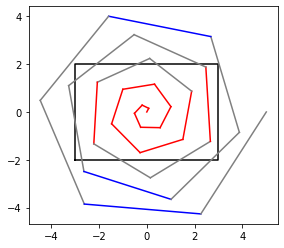

In [26]:
PlotRect (R)
ClipCurve (C, R, ClipLineCohenSutherland0)
Iso()

In [27]:
def ClipLineCohenSutherland1 (p, q, rect):
    f = ClipFlags (p, rect)
    g = ClipFlags (q, rect)
    if f == 0 and g == 0:
        PlotLine (p, q, 'blue')
    else:
        if f & g != 0:
            PlotLine (p, q, 'grey')
            ;
        else:
            if Dist (p, q) < 0.1:
                PlotLine (p, q, 'red')
            else:
                r = (p + q) / 2
                ClipLineCohenSutherland1 (p, r, rect)
                ClipLineCohenSutherland1 (r, q, rect)

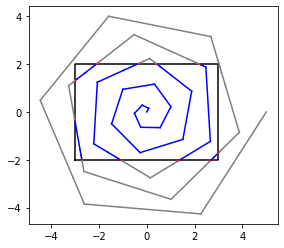

In [28]:
PlotRect (R)
ClipCurve (C, R, ClipLineCohenSutherland1)
Iso()

## Polygon Clipping: Sutherland-Hodgeman

In [29]:
def PlotPoly (polygon, color):
    pl.fill (polygon [0], polygon [1], color)

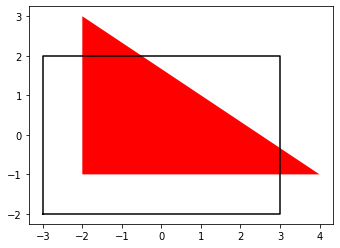

In [30]:
P1 = np.array ([
    [-2,  4, -2],
    [-1, -1,  3]
])

PlotRect (R)
PlotPoly (P1, 'red')
Iso()

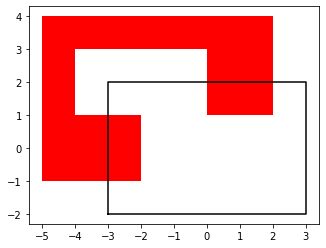

In [31]:
P2 = np.array ([
    [-4, -2, -2, -4, -4, 0, 0, 2, 2, -5, -5],
    [-1, -1,  1,  1,  3, 3, 1, 1, 4,  4, -1]
])

P = P2
PlotRect (R)
PlotPoly (P, 'red')
Iso()

In [32]:
def Intersection (p, q, a, n):
    v = q - p
    t = Dot (a - p, n) / Dot (v, n)
    return p + t * v

In [33]:
def ClipLineCohenSutherland (poly, a, b):
    inpoly = Cat (np.copy (poly), Col (poly, 0))
    #letzter Punkt
    outpoly = np.array ([[], []])
    u = b - a
    n = Vec (- u [1, 0], u [0, 0])
    s = Col (inpoly, 0); si = Dot (s - a, n) >= 0
    if si:
        outpoly = Cat (outpoly, s)
    for k in range (1, inpoly.shape [1]):
        p = Col (inpoly, k); pi = Dot (p - a, n) >= 0
        if si:
            if pi:
                outpoly = Cat (outpoly, p)
            else:
                i = Intersection (s, p, a, n)
                outpoly = Cat (outpoly, i)
        else:
            if pi:
                i = Intersection (s, p, a, n)
                outpoly = Cat (outpoly, i, p)
        s = p; si = pi
    return outpoly

In [34]:
RC = RectCurve (R)
Q0 = P1

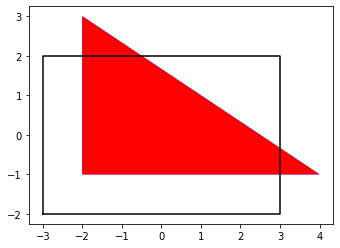

In [35]:
Q1 = ClipLineCohenSutherland (Q0, Col (RC, 0), Col (RC, 1))

PlotRect (R)
PlotPoly (Q0, 'blue')
PlotPoly (Q1, 'red')
Iso()

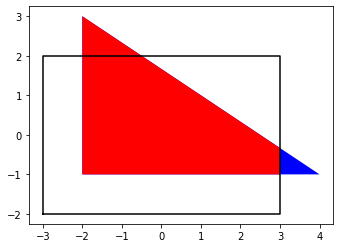

In [36]:
Q2 = ClipLineCohenSutherland (Q1, Col (RC, 1), Col (RC, 2))

PlotRect (R)
PlotPoly (Q0, 'blue')
PlotPoly (Q2, 'red')
Iso()

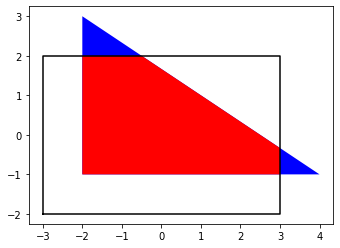

In [37]:
Q3 = ClipLineCohenSutherland (Q2, Col (RC, 2), Col (RC, 3))

PlotRect (R)
PlotPoly (Q0, 'blue')
PlotPoly (Q3, 'red')
Iso()

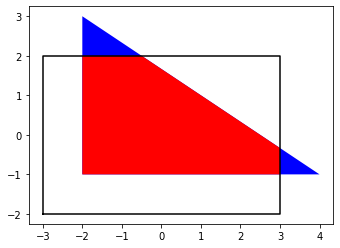

In [38]:
Q4 = ClipLineCohenSutherland (Q3, Col (RC, 3), Col (RC, 4))

PlotRect (R)
PlotPoly (Q0, 'blue')
PlotPoly (Q4, 'red')
Iso()

In [39]:
def ClipRectCohenSutherland (inpoly, rect):
    rc = RectCurve (R)
    a = Col (rc, 0)
    p = np.copy (inpoly)
    for k in range (1, rc.shape [1]):
        b = Col (rc, k)
        p = ClipLineCohenSutherland (p, a, b)
        a = b
    return p

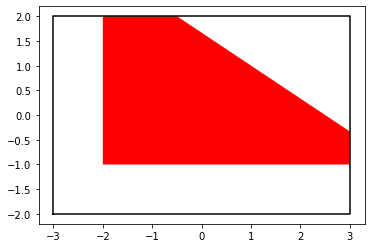

In [40]:
Q1 = ClipRectCohenSutherland (P1, R)
PlotRect (R)
PlotPoly (Q1, 'red')
Iso()

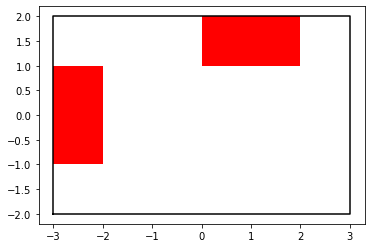

In [41]:
Q2 = ClipRectCohenSutherland (P2, R)
PlotRect (R)
PlotPoly (Q2, 'red')
Iso()